In [1]:
import gym
import gym_jumping_task
from gym_jumping_task.envs.jumping_task import JumpTaskEnv
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid
import torch.nn as nn
import augmentations
import torchvision.transforms.functional as fn
from env import VanillaEnv

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
device = torch.device('cpu')

env =  VanillaEnv()

Done! Episode Reward:  24.0


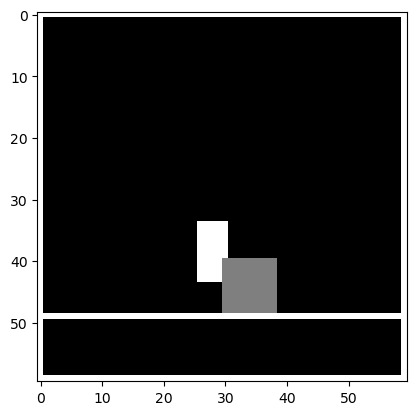

In [3]:
done = False
rewards = []
frames = []

state = env.reset()
while not done:
    action = np.random.randint(low=0, high=2)
    next_state, r, done, info = env.step(action)
    rewards.append(r)
    frames.append(np.expand_dims(np.flipud(state.squeeze()), axis=0))
    state = next_state
    if done: 
        print("Done! Episode Reward: ", np.sum(rewards))
        plt.imshow(np.flipud(state.squeeze()), cmap='gray', vmin=0, vmax=255)
        break

# Augmentations

In [4]:
# convert the frames from [0., 1.] to [0, 255]
# frames = np.array(np.array(frames) * 255, dtype=np.uint8)
# Convert the frame stack into the correct format (B, C, H, W)
frames = np.array(frames)
if len(frames.shape) == 3: frames = np.expand_dims(frames, axis=1)


print(frames.shape)
print(frames.dtype)

(26, 1, 60, 60)
uint8


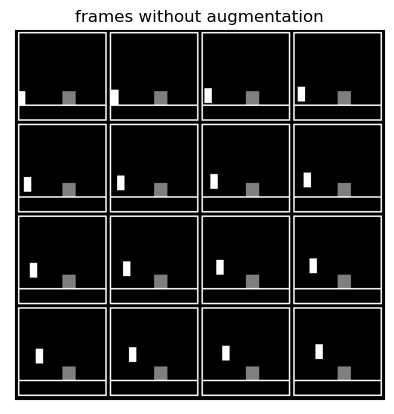

In [5]:
def show_imgs(x, max_display=16, title:str = ""):
    grid = make_grid(torch.from_numpy(x[:max_display]),4).permute(1,2,0).cpu().numpy()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(grid)
    if len(title) > 0: plt.title(title)
    plt.show()

show_imgs(frames, title="frames without augmentation")

(26, 1, 70, 70)


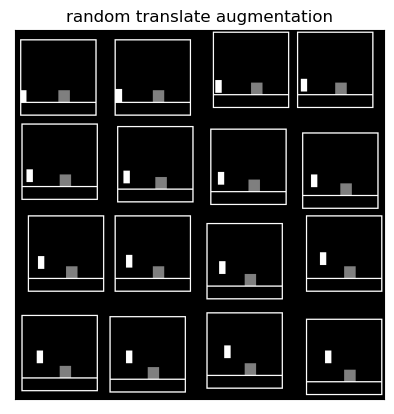

In [6]:
rnd_trans = augmentations.random_translate(frames,70)
print(rnd_trans.shape)
show_imgs(rnd_trans, title="random translate augmentation")

(26, 1, 60, 60)


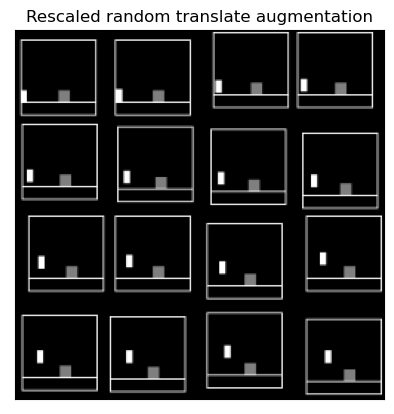

In [7]:
# Try to rescale images to 60x60
rnd_trans = fn.resize(torch.from_numpy(rnd_trans), size=[60,60]).numpy()
print(rnd_trans.shape)
show_imgs(rnd_trans, title="Rescaled random translate augmentation")

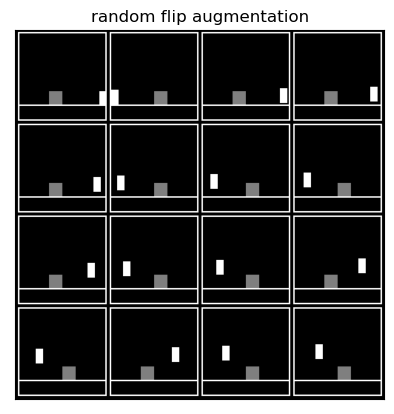

In [8]:
flipped_x = augmentations.random_flip(frames)
show_imgs(flipped_x, title="random flip augmentation")

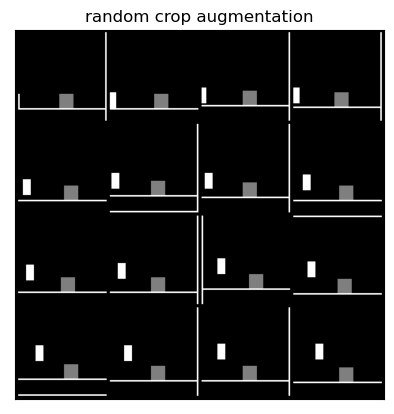

In [9]:
cropped_x = augmentations.random_crop(frames,56)
show_imgs(cropped_x, title="random crop augmentation")

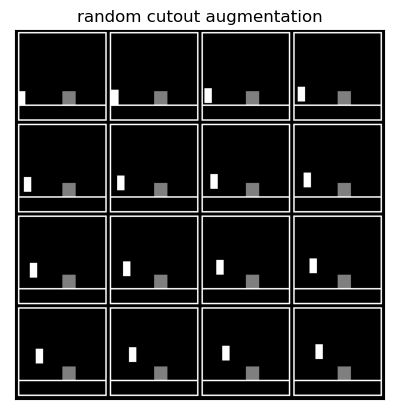

In [10]:
cut_x = augmentations.random_cutout(frames,10,15)
show_imgs(cut_x, title="random cutout augmentation")

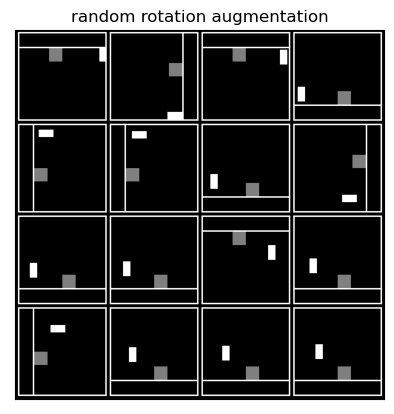

In [11]:
rnd_rotation = augmentations.random_rotation(frames,device)
show_imgs(rnd_rotation, title="random rotation augmentation")

================== 0 ==================
new augmentation:  {'func': <function identity at 0x0000014B8C2A3E50>, 'params': {}}


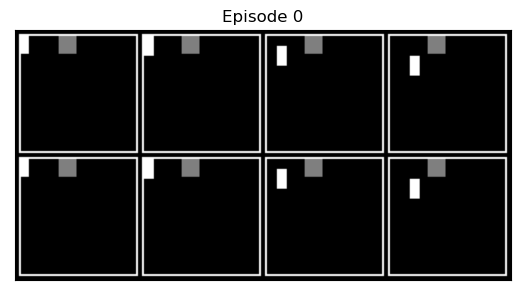

================== 1 ==================
new augmentation:  {'func': <function identity at 0x0000014B8C2A3E50>, 'params': {}}


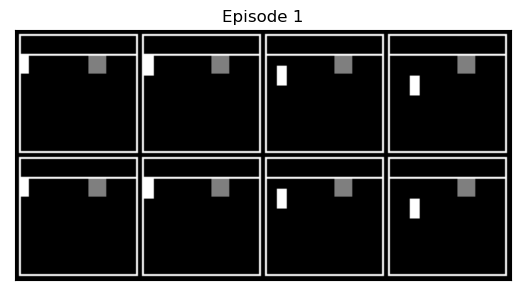

================== 2 ==================
new augmentation:  {'func': <function identity at 0x0000014B8C2A3E50>, 'params': {}}


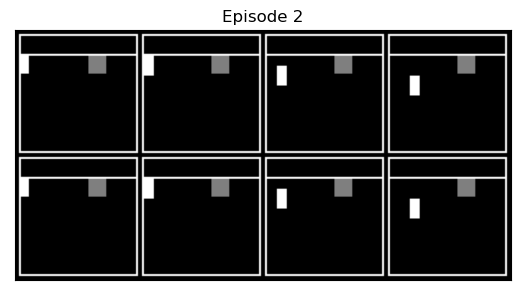

================== 3 ==================
new augmentation:  {'func': <function random_translate at 0x0000014B8C2A39D0>, 'params': {'size': 64}}


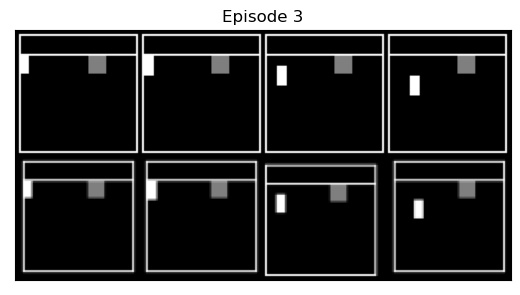

================== 4 ==================
new augmentation:  {'func': <function random_translate at 0x0000014B8C2A39D0>, 'params': {'size': 68}}


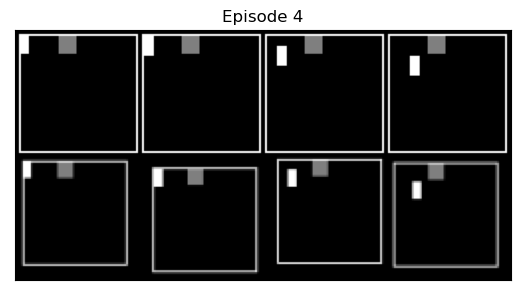

================== 5 ==================
new augmentation:  {'func': <function random_translate at 0x0000014B8C2A39D0>, 'params': {'size': 72}}


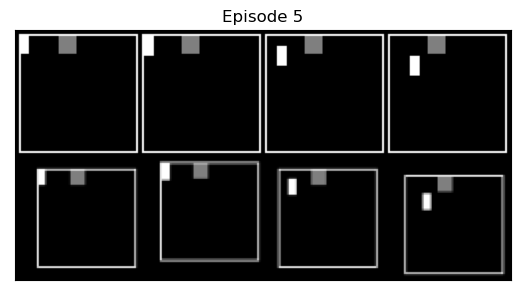

================== 6 ==================
new augmentation:  {'func': <function random_crop at 0x0000014B8C2A3C10>, 'params': {'out': 59}}


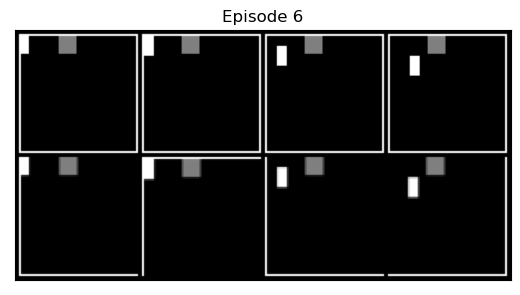

================== 7 ==================
new augmentation:  {'func': <function random_crop at 0x0000014B8C2A3C10>, 'params': {'out': 58}}


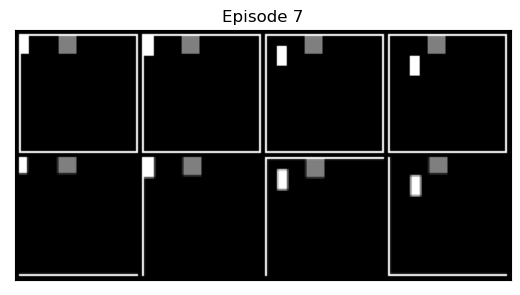

================== 8 ==================
new augmentation:  {'func': <function random_crop at 0x0000014B8C2A3C10>, 'params': {'out': 57}}


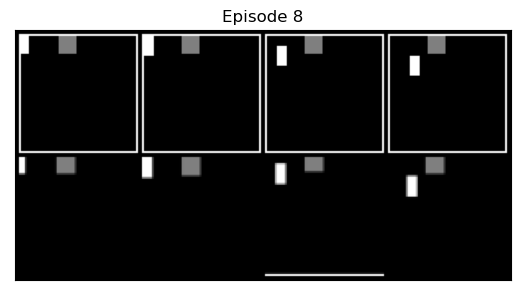

================== 9 ==================
new augmentation:  {'func': <function random_cutout at 0x0000014B8C2A3CA0>, 'params': {'min_cut': 2, 'max_cut': 5}}


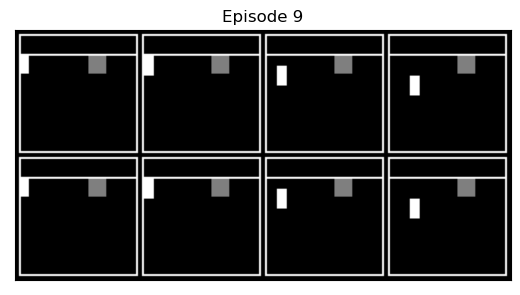

================== 10 ==================
new augmentation:  {'func': <function random_cutout at 0x0000014B8C2A3CA0>, 'params': {'min_cut': 5, 'max_cut': 15}}


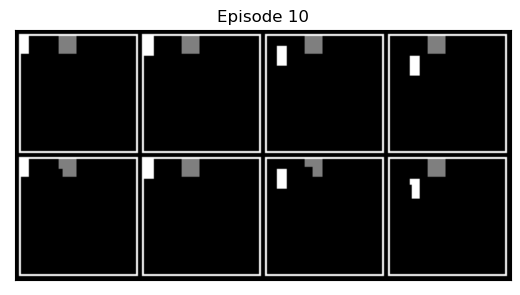

================== 11 ==================
new augmentation:  {'func': <function random_cutout at 0x0000014B8C2A3CA0>, 'params': {'min_cut': 10, 'max_cut': 20}}


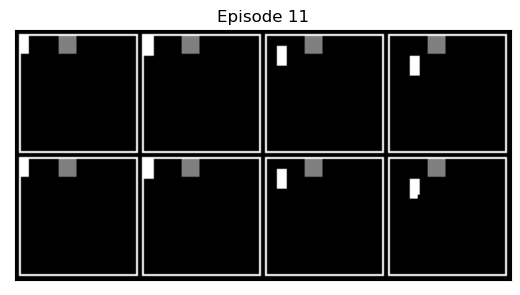

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================== 12 ==================
new augmentation:  {'func': <function random_noise at 0x0000014B8C2A3DC0>, 'params': {'strength': 0.02}}


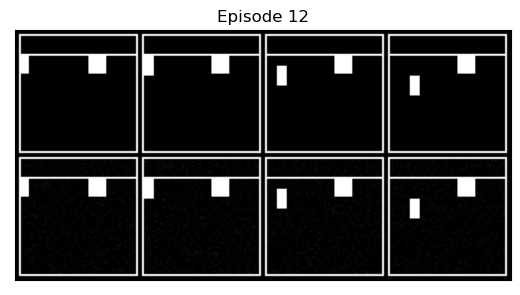

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================== 13 ==================
new augmentation:  {'func': <function random_noise at 0x0000014B8C2A3DC0>, 'params': {'strength': 0.05}}


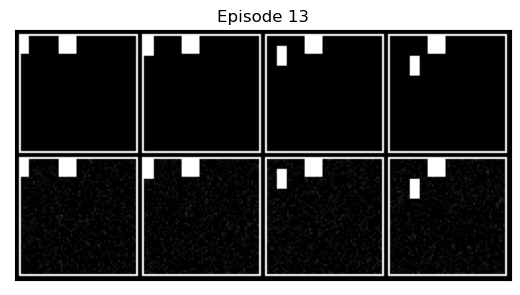

In [12]:
from env import POSSIBLE_AUGMENTATIONS, UCBAugmentingEnv

"""
UCB selects each transformation once when starting up. 
Thus if we play the first n episodes we should see all n Augmentations in action
"""

env = UCBAugmentingEnv(configurations=[(20, 0), (35, 10)])

for i in range(len(POSSIBLE_AUGMENTATIONS)):
    print(f"================== {i} ==================")
    aug_obs, ori_obs = env.reset_augmented()
    aug_observations = [aug_obs, ]
    ori_observations = [ori_obs, ]

    for j in range(15):
        aug_obs, ori_obs, r, done, info = env.step_augmented(1)
        if j % 5 == 0: aug_observations.append(aug_obs)
        if j % 5 == 0: ori_observations.append(ori_obs)
    
    
    frames = np.array(ori_observations+aug_observations)
    # Convert the frame stack into the correct format (B, C, H, W)
    if len(frames.shape) == 3: frames = np.expand_dims(frames, axis=1)
    
    show_imgs(frames, title=f"Episode {i}", max_display=8)
    